In [1]:
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm_notebook
import shutup; shutup.please()

In [2]:
data = pd.read_csv('./cmpd_descriptions.csv')

In [3]:
pd.set_option('max_colwidth', None)
data.head()

,Unnamed: 0,CID,Description
0,0,1697,"4,5-dianilinophthalimide is phthalimide substituted at the 4- and 5-positions by anilino groups. It has a role as a tyrosine kinase inhibitor and a geroprotector."
1,1,755673,"7-hydroxy-2,3,4,5-tetrahydrobenzofuro[2,3-c]azepin-1-one is a member of benzofurans."
2,2,15160711,Ovalitenin B is a butanone.
3,3,176870,"Erlotinib is a quinazoline compound having a (3-ethynylphenyl)amino group at the 4-position and two 2-methoxyethoxy groups at the 6- and 7-positions. It has a role as an antineoplastic agent, a protein kinase inhibitor and an epidermal growth factor receptor antagonist. It is a member of quinazolines, a terminal acetylenic compound, an aromatic ether and a secondary amino compound."
4,4,656344,"2-[[5-(4-methylphenyl)-1,3,4-oxadiazol-2-yl]thio]-1-(4-phenyl-1-piperazinyl)ethanone is a member of piperazines."


In [4]:
data.shape

(4095, 3)

# Preprocessing of texts for topic modeling by LDA

In [5]:
import nltk

In [6]:
word_tokenizer = nltk.WordPunctTokenizer()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ivanikova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stop_words = nltk.corpus.stopwords.words('english')

In [8]:
# adding custom stop words for compound descriptions
text_file = open('./custom_stop_words.txt', 'r')
custom_stop_words = text_file.read().split(',')

In [9]:
custom_stop_words[:5]

['is', ' has', ' it', ' thus', ' therefore']

In [10]:
all_stop_words = stop_words + custom_stop_words

In [11]:
import re

In [12]:
regex = re.compile(r'[a-zA-Z]+')
def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text)).lower()
    except:
        return ""

In [13]:
def process_data(data):
    texts = []
    for index, row in tqdm(data.iterrows(), total=len(data)):
        text_lower = words_only(row['Description'])
        tokens = word_tokenizer.tokenize(text_lower)
        tokens = [word for word in tokens if (word not in all_stop_words and not word.isnumeric())]
        texts.append(tokens)
    return texts

In [14]:
texts = process_data(data)

100%|█████████████████████████████████████████████████████████████████████████████| 4095/4095 [00:00<00:00, 7563.18it/s]


In [15]:
from nltk.stem.snowball import SnowballStemmer

In [16]:
stemmer = SnowballStemmer('english')

In [17]:
for i in range(len(texts)):
    text_stemmed = [stemmer.stem(x) for x in texts[i]]
    texts[i] = text_stemmed

# Topic modeling by LDA 

In [18]:
from gensim.models import *
from gensim import corpora

In [19]:
dictionary = corpora.Dictionary(texts)
print('Original: {}'.format(dictionary))
dictionary.filter_extremes(no_below = 2, keep_n=None)
dictionary.save('descriptions.dict')
print('Filtered: {}'.format(dictionary))
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('descriptions.model', corpus) 

Original: Dictionary<7126 unique tokens: ['anilino', 'dianilinophthalimid', 'geroprotector', 'group', 'inhibitor']...>
Filtered: Dictionary<2877 unique tokens: ['anilino', 'geroprotector', 'group', 'inhibitor', 'kinas']...>


In [20]:
lda_model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics = 3, chunksize=50, update_every=1, passes=10, per_word_topics=True)

In [21]:
lda_model.show_topics(num_words=15, formatted = False)

[(0,
  [('agent', 0.03594482),
   ('group', 0.035181977),
   ('role', 0.034937076),
   ('member', 0.032143515),
   ('inhibitor', 0.0278651),
   ('posit', 0.027255164),
   ('compound', 0.02212695),
   ('drug', 0.017643416),
   ('substitut', 0.01758891),
   ('use', 0.015208351),
   ('ec', 0.015015094),
   ('class', 0.013556496),
   ('antagonist', 0.012746102),
   ('amino', 0.009460279),
   ('anti', 0.008940653)]),
 (1,
  [('member', 0.07816056),
   ('n', 0.05284349),
   ('yl', 0.041580923),
   ('methyl', 0.03583594),
   ('h', 0.027270082),
   ('phenyl', 0.019967606),
   ('compound', 0.017798344),
   ('amino', 0.017050184),
   ('aromat', 0.016612457),
   ('ethyl', 0.013447854),
   ('amid', 0.012421364),
   ('benzamid', 0.011763985),
   ('one', 0.010154557),
   ('oxo', 0.0101249805),
   ('dimethyl', 0.008583943)]),
 (2,
  [('acid', 0.1414815),
   ('metabolit', 0.045408193),
   ('role', 0.032236353),
   ('group', 0.029799448),
   ('amino', 0.021739736),
   ('function', 0.020766968),
   ('re

# Number of documents per dominant topic

In [22]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

In [23]:
dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

topic_top_words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 9]

df_top_words_stacked = pd.DataFrame(topic_top_words, columns=['topic_id', 'words'])
df_top_words = df_top_words_stacked.groupby('topic_id').agg(', \n'.join)
df_top_words.reset_index(level=0,inplace=True)

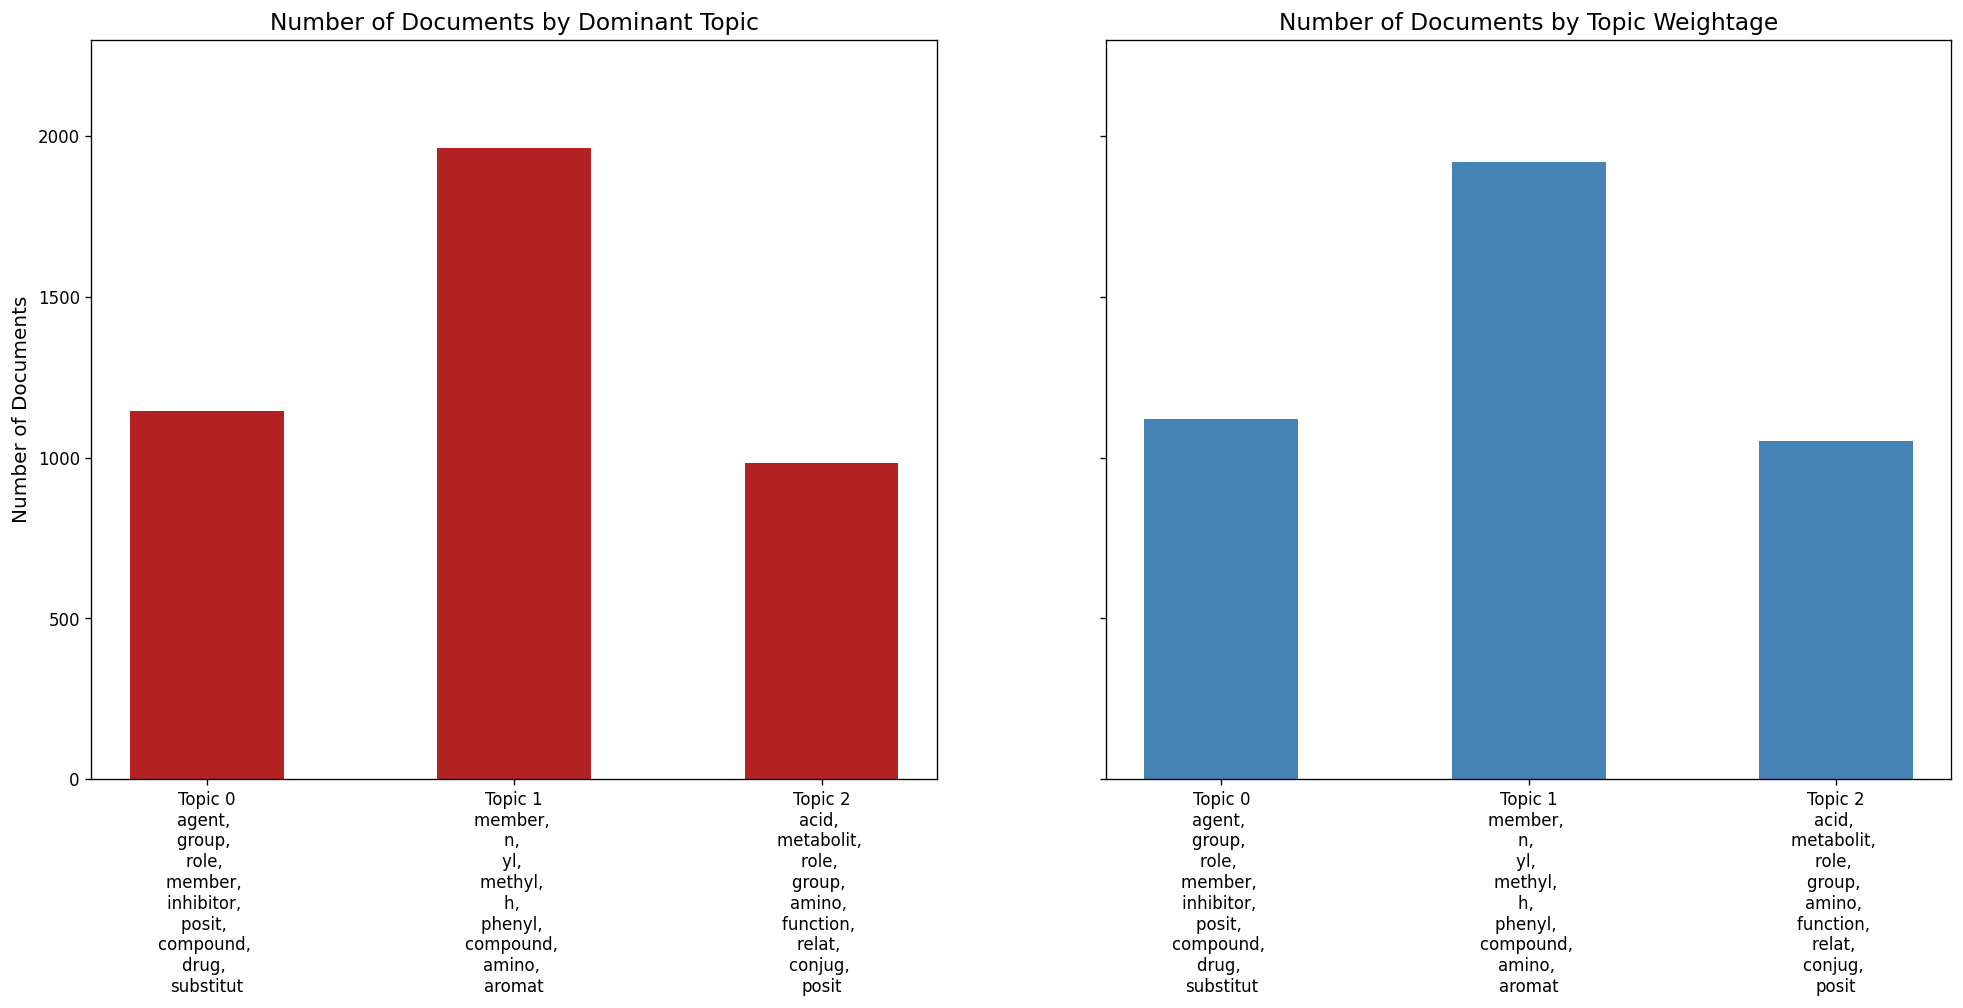

In [24]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=120, sharey=True)
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top_words.loc[df_top_words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=14))
ax1.set_ylabel('Number of Documents', fontdict=dict(size=12))
ax1.set_ylim(0, 2300)
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=14))
plt.show()

# Assigning dominant topics to descriptions as clasification labels

In [25]:
def format_topics_sent(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df._append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_topic', 'Perc_Contrib', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.rename(columns={0: "Text"}, inplace=True)
    return sent_topics_df

In [26]:
sent_topics = format_topics_sent(lda_model, corpus, texts)
sent_topics.head()

,Dominant_topic,Perc_Contrib,Topic_Keywords,Text
0,0,0.7576,"agent, group, role, member, inhibitor, posit, compound, drug, substitut, use","[dianilinophthalimid, phthalimid, substitut, posit, anilino, group, role, tyrosin, kinas, inhibitor, geroprotector]"
1,1,0.8949,"member, n, yl, methyl, h, phenyl, compound, amino, aromat, ethyl","[hydroxi, tetrahydrobenzofuro, c, azepin, one, member, benzofuran]"
2,1,0.7756,"member, n, yl, methyl, h, phenyl, compound, amino, aromat, ethyl","[ovalitenin, b, butanon]"
3,0,0.8657,"agent, group, role, member, inhibitor, posit, compound, drug, substitut, use","[erlotinib, quinazolin, compound, ethynylphenyl, amino, group, posit, two, methoxyethoxi, group, posit, role, antineoplast, agent, protein, kinas, inhibitor, epiderm, growth, factor, receptor, antagonist, member, quinazolin, termin, acetylen, compound, aromat, ether, secondari, amino, compound]"
4,1,0.9330,"member, n, yl, methyl, h, phenyl, compound, amino, aromat, ethyl","[methylphenyl, oxadiazol, yl, thio, phenyl, piperazinyl, ethanon, member, piperazin]"


In [27]:
topic_modeling_desc_labels = pd.merge(data, sent_topics, left_index=True, right_index=True)
topic_modeling_desc_labels.Dominant_topic = topic_modeling_desc_labels.Dominant_topic.map({0: 'Drug', 1: 'No annotation', 2: 'Metabolite'})
topic_modeling_desc_labels.head()

,Unnamed: 0,CID,Description,Dominant_topic,Perc_Contrib,Topic_Keywords,Text
0,0,1697,"4,5-dianilinophthalimide is phthalimide substituted at the 4- and 5-positions by anilino groups. It has a role as a tyrosine kinase inhibitor and a geroprotector.",Drug,0.7576,"agent, group, role, member, inhibitor, posit, compound, drug, substitut, use","[dianilinophthalimid, phthalimid, substitut, posit, anilino, group, role, tyrosin, kinas, inhibitor, geroprotector]"
1,1,755673,"7-hydroxy-2,3,4,5-tetrahydrobenzofuro[2,3-c]azepin-1-one is a member of benzofurans.",No annotation,0.8949,"member, n, yl, methyl, h, phenyl, compound, amino, aromat, ethyl","[hydroxi, tetrahydrobenzofuro, c, azepin, one, member, benzofuran]"
2,2,15160711,Ovalitenin B is a butanone.,No annotation,0.7756,"member, n, yl, methyl, h, phenyl, compound, amino, aromat, ethyl","[ovalitenin, b, butanon]"
3,3,176870,"Erlotinib is a quinazoline compound having a (3-ethynylphenyl)amino group at the 4-position and two 2-methoxyethoxy groups at the 6- and 7-positions. It has a role as an antineoplastic agent, a protein kinase inhibitor and an epidermal growth factor receptor antagonist. It is a member of quinazolines, a terminal acetylenic compound, an aromatic ether and a secondary amino compound.",Drug,0.8657,"agent, group, role, member, inhibitor, posit, compound, drug, substitut, use","[erlotinib, quinazolin, compound, ethynylphenyl, amino, group, posit, two, methoxyethoxi, group, posit, role, antineoplast, agent, protein, kinas, inhibitor, epiderm, growth, factor, receptor, antagonist, member, quinazolin, termin, acetylen, compound, aromat, ether, secondari, amino, compound]"
4,4,656344,"2-[[5-(4-methylphenyl)-1,3,4-oxadiazol-2-yl]thio]-1-(4-phenyl-1-piperazinyl)ethanone is a member of piperazines.",No annotation,0.9330,"member, n, yl, methyl, h, phenyl, compound, amino, aromat, ethyl","[methylphenyl, oxadiazol, yl, thio, phenyl, piperazinyl, ethanon, member, piperazin]"


In [28]:
topic_modeling_desc_labels.to_csv('./description_classification.csv', index=False)